# Ejercicio clase 5: CNN-score
El objetivo es armar una arquitectura tipo CNN que identifique el dataset MNIST, tal que logre el mejor score dado por:

$$ score = \frac{1}{log_{10}(n\_parameter)} * \frac{10}{n\_epochs}*test\_acc*n\_layers$$

donde:
*   `test_acc`: valor de accuracy.
*   `n_parameter`: cantidad de parámetros generados por la red.
*   `n_layers`: cantidad de capas empleadas (conv + activacion + pooling = 1 capa).
*   `n_epochs` de entrenamiento usadas.

El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

## Librerías necesarias

In [2]:
import torch
import torchvision
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

## Configuración del _device_

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Resolución

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1. Carga de dataset

In [5]:
# Lectura y carga de los dataset en formato pickle

def cargarArchivo(ruta):
    file = open(ruta,"rb")
    datos = pickle.load(file)
    file.close()
    return datos

def normaliza(ds):
    # I can get what I want from below for-loop solution
    batches = ds.shape[0]
    for i in range(batches):
        ds[i] -= torch.min(ds[i])
        ds[i] /= torch.max(ds[i])

In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/DL/data'
test_label = torch.from_numpy(cargarArchivo(path+"/test_label.pkl"))
test = torch.from_numpy(cargarArchivo(path+"/test.pkl")).type(torch.FloatTensor)
train_label = torch.from_numpy(cargarArchivo(path+"/train_label.pkl"))
train = torch.from_numpy(cargarArchivo(path+"/train.pkl")).type(torch.FloatTensor)
val_label = torch.from_numpy(cargarArchivo(path+"/val_label.pkl"))
val = torch.from_numpy(cargarArchivo(path+"/val.pkl")).type(torch.FloatTensor)

In [7]:
normaliza(train)
normaliza(test)
normaliza(val)

In [8]:
#paso a shape num_muestras, chanel, H, W
train = torch.unsqueeze(train,1)
test = torch.unsqueeze(test,1)
val = torch.unsqueeze(val,1)

In [9]:
class CNNDataset(Dataset):
    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)
        
    def __getitem__(self, idx):
        x = self.X_Train[idx]
        y = self.Y_Train[idx]
        return x, y

In [10]:
train_dataset = CNNDataset(train, train_label)
test_dataset =  CNNDataset(test, test_label)
validation_dataset = CNNDataset(val, val_label)

In [11]:
batch_size = 64
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True),
    'validation': torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    }

In [12]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


### 2. Verificación  del dataset

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


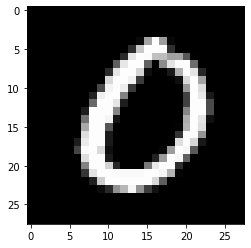

Label: 0


In [13]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### 3. Construyo la CNN

In [14]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 64)
    self.conv2_out = None
    self.conv3 = block(64, 128)
    self.conv3_out = None
    self.conv4 = block(128, 128)
    self.conv4_out = None
    self.fc = torch.nn.Linear(128*2*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling): ', i-2)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    y = self.sm(y)
    # x = self.sm(x)
    return y

Se crea el modelo

In [15]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Número total de capas de CNN (conv+act+polling):  4
Número total de parámet

### 4. Revisión de dimensiones

Para verificar dimensiones, al correr el bloque, indicar el tamaño de las imágenes. En este caso es igaul a 28 (son de 28x28).

In [16]:
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 14, 14])
Tamaño salida conv2:  torch.Size([1, 64, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño salida conv4:  torch.Size([1, 128, 2, 2])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


### 5. Funciones de entrenamiento

In [17]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### 6. Entrenamiento de la red

In [18]:
# Definición de la cantidad de epochs
fit(model, dataloader)

val_loss 1.60016 val_acc 0.86823: 100%|██████████| 110/110 [00:00<00:00, 169.91it/s]


Epoch 1/4 loss 1.77310 val_loss 1.60016 acc 0.70913 val_acc 0.86823


val_loss 1.57994 val_acc 0.88414: 100%|██████████| 110/110 [00:00<00:00, 182.19it/s]


Epoch 2/4 loss 1.59576 val_loss 1.57994 acc 0.87036 val_acc 0.88414


val_loss 1.57267 val_acc 0.88982: 100%|██████████| 110/110 [00:00<00:00, 173.57it/s]


Epoch 3/4 loss 1.58236 val_loss 1.57267 acc 0.88138 val_acc 0.88982


val_loss 1.57128 val_acc 0.89062: 100%|██████████| 110/110 [00:00<00:00, 181.52it/s]

Epoch 4/4 loss 1.57578 val_loss 1.57128 acc 0.88623 val_acc 0.89062


### 7. Verifico que funcione

torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


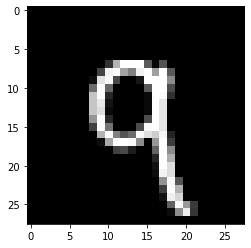

torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[3.8657e-08, 2.6740e-08, 1.0288e-07, 1.3349e-06, 5.4481e-07, 7.5082e-14,
         1.7938e-10, 9.9466e-04, 1.6778e-06, 9.9900e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
softmax de predicción:
tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0854, 0.0853,
         0.2318]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
El numero es un:  9


In [19]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 50

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))
# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print(samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat)
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

### Accuracy del test

In [20]:
def check_accuracy(test_loader, device):
    num_correct = 0
    total = 0
    model.eval()
    val_acc = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data)
            acc = (labels == torch.argmax(predictions, axis=1)).sum().item() / len(labels)
            val_acc.append(acc)

        print(f"val_acc {np.mean(val_acc):.5f}")
        return np.mean(val_acc)

In [21]:
test_accuracy = check_accuracy(dataloader['test'], device)

val_acc 0.89062


## Score   

El modelo original, de acuerdo a la fórmula propuesta, obtuvo el siguiente valor,

$$ score = 0.9788 $$

In [22]:
total_params = 264138
epochs = 4
n_layers = 4

score = (1/np.log10(total_params))*(10/epochs)*test_accuracy*4
score

1.6426646623066496

Se logró mejorar el score del caso original. 

$$ score_{nuevo} = 1.6426 $$